In [1]:
import heeps
from copy import deepcopy
from heeps.wavefront.get_array import show_wf, get_wf
from heeps.util.psf_template import psf_template
from heeps.util.lamD import get_lamD_mas
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import vip_hci

In [2]:
def get_band_mode(case):
    band_mode = {'ELT-L' :  ('L', 'ELT'),
                 'ELT-N' :  ('N2', 'ELT'),
                 'IMG-LM' : ('L', 'IMG'),# "spider mask"
                 'APP-LM' : ('L', 'APP'),
                 'SPP-LM' : ('L', 'SPP'),
                 'RLS-LM' : ('L', 'RAVC'),
                 'CLS-LM' : ('L', 'CVC'),
                 'ULS-LM' : ('L', 'CLC'),
                 'IMG-N'  : ('N2', 'IMG'),# "spider mask"
                 'CLS-N'  : ('N2', 'CVC'),
                 'ULS-N'  : ('N2', 'CLC'),
                 'LMS'    : ('L', 'LMS'),
                 'APP-LMS': ('L', 'APP'),
                 'RLS-LMS': ('L', 'RAVC'),
                 'CLS-LMS': ('L', 'CVC'),
                 'ULS-LMS': ('L', 'CLC')}
    return band_mode[case]

def get_margins(case):
    ls_dR = {'ELT-L' :  {'stop_params' : (0, 0, 0), 'force_sym': False},
             'ELT-N' :  {'stop_params' : (0, 0, 0), 'force_sym': False},
             'IMG-LM' : {'stop_params' : (2.09, 2.09, 3.17), 'force_sym': False},
             'APP-LM' : {'stop_params' : (2.09, 2.09, 3.31), 'force_sym': False},# load fits file
             'SPP-LM' : {'stop_params' : (0, 0, 0), 'force_sym': False}, # SPP defines its own stop
             'RLS-LM' : {'stop_params' : (4.77, 4.00, 2.75), 'force_sym': False}, # one spider is thicker
             'CLS-LM' : {'stop_params' : (2.09, 9.00, 2.71), 'force_sym': False},# one spider is thicker
             'ULS-LM' : {'stop_params' : (10.95, 4.91, 3.43), 'force_sym': False},
             'IMG-N'  : {'stop_params' : (2.68, 2.68, 3.83), 'force_sym': False},
             'CLS-N'  : {'stop_params' : (2.68, 9.00, 3.83), 'force_sym': False},# one spider is thicker
             'ULS-N'  : {'stop_params' : (10.45, 5.11, 4.09), 'force_sym': False},
             'LMS'    : {'stop_params' : (2.41, 2.41, 3.34), 'force_sym': True},
             'APP-LMS': {'stop_params' : (2.41, 2.41, 3.48), 'force_sym': True},# load fits file
             'RLS-LMS': {'stop_params' : (4.68, 4.00, 3.06), 'force_sym': True}, # one spider is thicker
             'CLS-LMS': {'stop_params' : (2.18, 9.00, 3.14), 'force_sym': True},
             'ULS-LMS': {'stop_params' : (10.95, 4.91, 3.43), 'force_sym': True},
             }
    return np.round(np.array(ls_dR[case]['stop_params'])/100, 4), ls_dR[case]['force_sym']

def get_throughput(cases, ELT_aper_flux=None, spp_trans=0.90, lom_trans=0.92, verbose=False):
    for case in cases:
        print(f'Processing case {case}:')
        band, mode = get_band_mode(case)
        (ls_dRext, ls_dRint, ls_dRspi), force_sym = get_margins(case)
        f_app_amp = 'optics/app/METIS_%s.fits'%('LMS_aper' if 'LMS' in case else 'IMG_aper_rot')
        f_app_phase = 'optics/app/METIS_%s.fits'%('LMS_vAPP_final' if 'LMS' in case else 'IMG_vAPP_final_rot')
        f_spp_amp = 'optics/spp/SP_AP2_masked_rot_crop_bin.fits'
        f_pupil='pupil/ELT_fullM1_feb2025.fits'
        conf = dict(band=band, mode=mode, nframes=1, add_phase=False, 
                    f_app_phase=f_app_phase, f_app_amp=f_app_amp, f_spp_amp=f_spp_amp,
                    ls_dRext=ls_dRext, ls_dRint=ls_dRint, ls_dRspi=ls_dRspi, force_sym=force_sym,
                    f_pupil=f_pupil)

        conf = heeps.config.read_config(**conf)
        conf = heeps.config.update_config(**conf, verbose=verbose)
        wf = heeps.pupil.pupil(**conf)
        amp = get_wf(wf, 'amp', npupil=conf['npupil'])
        # ELT PSF
        ELT_psf = heeps.optics.detector(deepcopy(wf), **conf)
        _, ELT_fwhm, ELT_aper_flux = psf_template(ELT_psf)
        (ny, nx) = ELT_psf.shape
        (cx, cy) = (nx//2, ny//2)
        print('ELT: fwhm=%.2fpix, aper_flux=%.4f, (cx,cy)=(%.1f,%.1f)'%(ELT_fwhm, ELT_aper_flux, cx, cy))
        if 'ELT' in mode:
            PSF = ELT_psf
            TOTAL = 1
            mode_thruput = 1
            mask_thruput = 1
        else: # other modes
            onaxis = True if mode in ['APP', 'SPP'] else False
            wf = heeps.optics.apodizer(wf, onaxis=onaxis, verbose=verbose, **conf)
            wf = heeps.optics.lyot_stop(wf, verbose=verbose, **conf)
            amp = get_wf(wf, 'amp', npupil=conf['npupil'])
            mode_thruput = np.sum(amp**2)
            mask_thruput = mode_thruput * 1
            PSF = heeps.optics.detector(wf, **conf)
            # FWHM aperture photometry
            aper_flux = vip_hci.metrics.aperture_flux(PSF, [cy], [cx], ELT_fwhm, verbose=False)[0]
            if 'APP' in mode:
                aper_flux *= conf['app_single_psf']
                mode_thruput *= conf['app_single_psf']
            # if 'APP' in mode:
            #     pupil_throughtput = np.sum(get_wf(wf, 'amp')**2)
            #     #print('pupil throughput (wrt ELT) = %.4f'%pupil_throughtput)
            #     aper_flux = ELT_aper_flux*pupil_throughtput*conf['app_strehl']*conf['app_single_psf']
            #     print('(APP Strehl = %s, single PSF = %s) aper_flux = %.4f'%(conf['app_strehl'], conf['app_single_psf'], aper_flux))    
            # if 'ELT' in mode:
            #     pass
            # printing the pure effect of PSF deformation, not taking into account any other effect (pupil mask, material, etc)
            print('This mode FWHM throughput (wrt ELT) = %.4f'%(aper_flux/ELT_aper_flux/mode_thruput))
            if 'VC' in mode:
                data = fits.getdata(conf['f_vc_trans'])
                mask_trans = np.interp(conf['lam']*1e6, data[0], data[1])
                print('VPM transmittance = %.4f'%mask_trans)
            elif 'APP' in mode:
                data = fits.getdata(conf['f_app_trans'])
                mask_trans = np.interp(conf['lam']*1e6, data[0], data[1])
                print('APP transmittance = %.4f'%mask_trans)
            elif 'SPP' in mode:
                mask_trans = spp_trans # cf. MAIT ZnSe QA -- 90% = estimation for 5mm extrapolated from 2mm data, needs update based on measurement
                print('SPP transmittance = %.4f'%mask_trans)        
            elif 'CLC' in mode:
                mask_trans = lom_trans # cf. MAIT ZnSe QA -- 92% = based on Artemis data + lab measurements
                print('LOM transmittance = %.4f'%mask_trans)        
            else:
                mask_trans = 1
            TOTAL =  aper_flux/ELT_aper_flux * mask_trans
            mode_thruput *= mask_trans

        print('Mask throughput = %.4f'%mask_thruput)
        print('Mode throughput = %.4f'%mode_thruput)
        print('Encircled energy throughput = %.4f'%TOTAL)

        if 'VC' in mode:
            oat = fits.getdata(conf['dir_input'] + 'optics/vc/oat_%s_%s.fits'%(band, mode))
            npix = 5*get_lamD_mas(**conf)/conf['pscale']
            oat5 = np.interp(npix, oat[0], oat[1])
            print('OAT @ 5 lambda/D = %.4f'%oat5)
            print('Encircled energy throughput @ 5 lambda/D = %.4f'%(TOTAL*oat5))

        # Figure
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(amp, origin='lower')
        axes[0].set_title('ls_dRext=%.2f, ls_dRint=%.2f, ls_dRspi=%.2f'%(ls_dRext*100, ls_dRint*100, ls_dRspi*100))
        axes[1].imshow(np.log10(PSF), origin='lower')
        axes[1].set_title('PSF sum = %.4f'%np.sum(PSF))
        plt.tight_layout()
        plt.show()
    return

# ELT aperture photometry

Processing case ELT-L:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
Mask throughput = 1.0000
Mode throughput = 1.0000
Encircled energy throughput = 1.0000


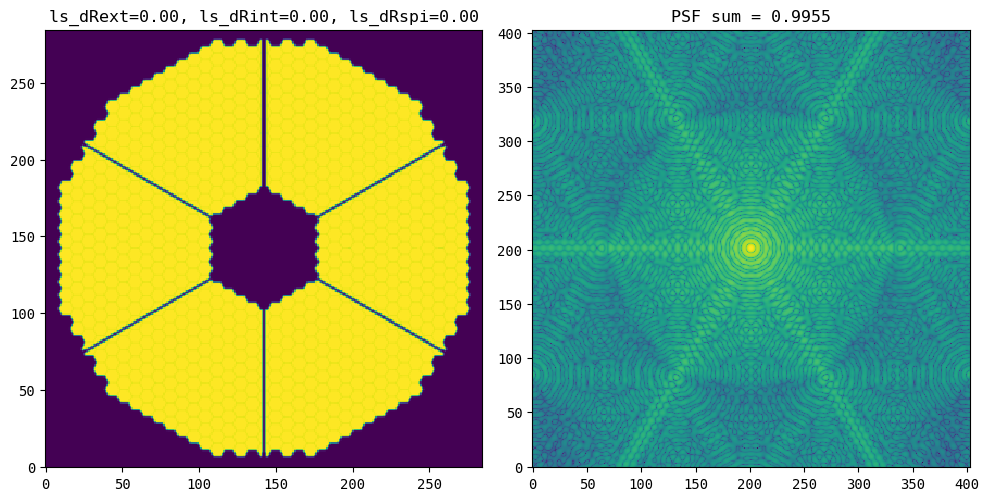

Processing case ELT-N:
ELT: fwhm=8.53pix, aper_flux=0.3776, (cx,cy)=(162.0,162.0)
Mask throughput = 1.0000
Mode throughput = 1.0000
Encircled energy throughput = 1.0000


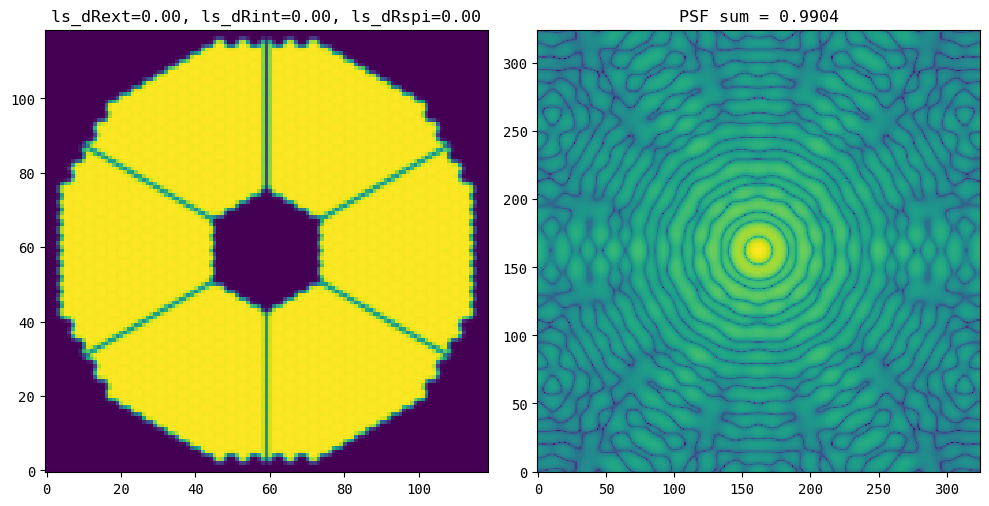

In [3]:
get_throughput(['ELT-L', 'ELT-N']);

# IMG modes
### LM bands

Processing case IMG-LM:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.8284
Mask throughput = 0.8224
Mode throughput = 0.8224
Encircled energy throughput = 0.6812


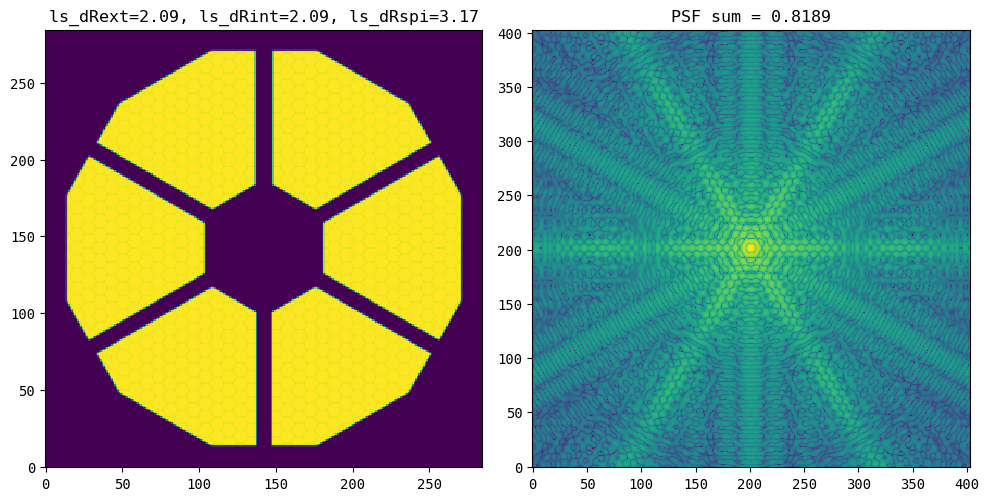

Processing case APP-LM:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.5387
APP transmittance = 0.7334
Mask throughput = 0.7986
Mode throughput = 0.2811
Encircled energy throughput = 0.1514


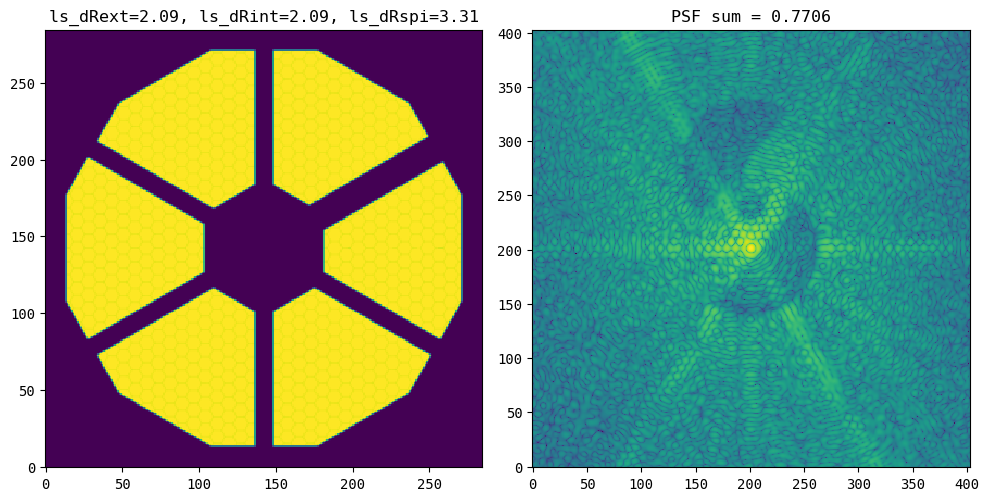

Processing case SPP-LM:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.4857
SPP transmittance = 0.9000
Mask throughput = 0.4449
Mode throughput = 0.4004
Encircled energy throughput = 0.1945


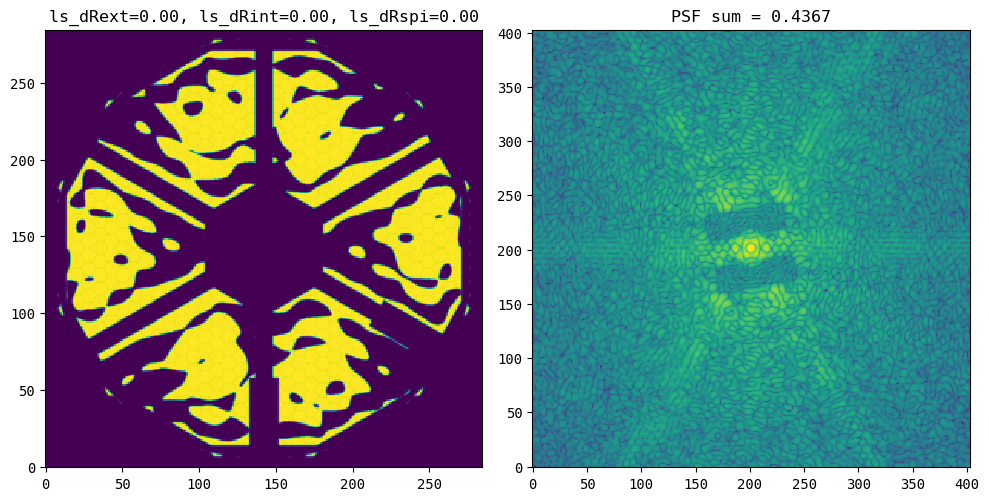

Processing case RLS-LM:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.5651
VPM transmittance = 0.8532
Mask throughput = 0.3636
Mode throughput = 0.3103
Encircled energy throughput = 0.1753
OAT @ 5 lambda/D = 0.8829
Encircled energy throughput @ 5 lambda/D = 0.1548


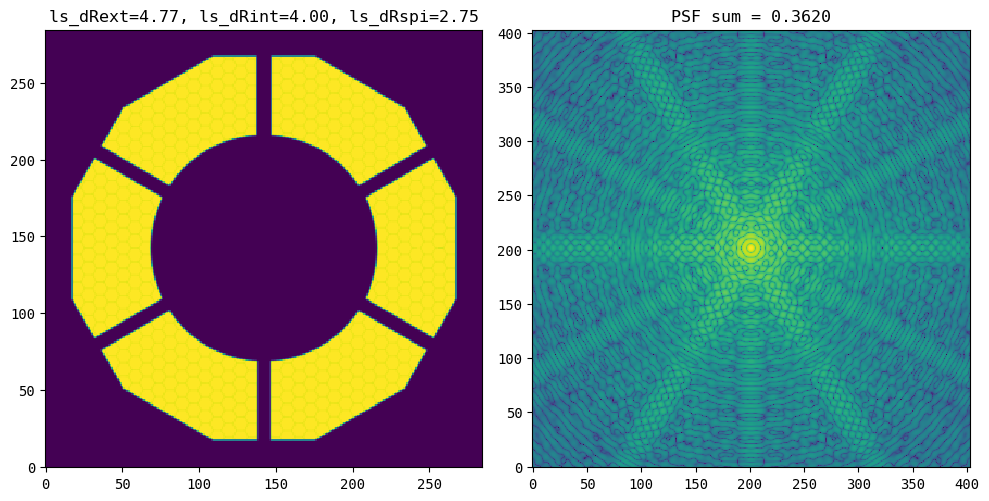

Processing case CLS-LM:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.7880
VPM transmittance = 0.8532
Mask throughput = 0.7913
Mode throughput = 0.6752
Encircled energy throughput = 0.5320
OAT @ 5 lambda/D = 0.8188
Encircled energy throughput @ 5 lambda/D = 0.4356


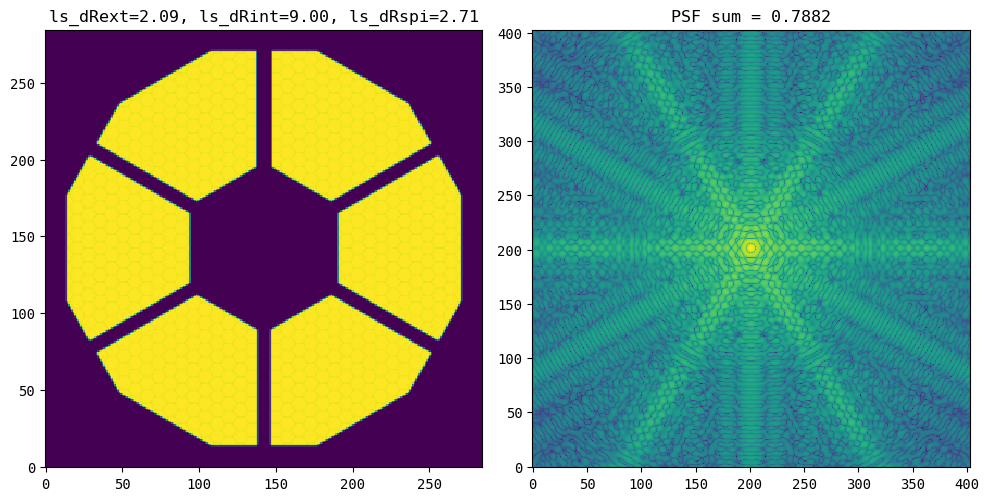

Processing case ULS-LM:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.6626
LOM transmittance = 0.9200
Mask throughput = 0.6297
Mode throughput = 0.5793
Encircled energy throughput = 0.3838


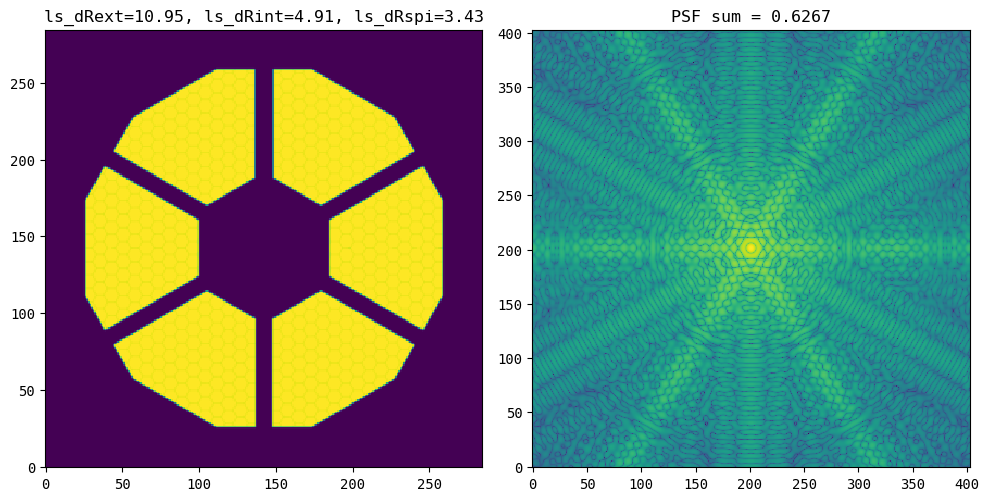

In [4]:
get_throughput(['IMG-LM','APP-LM','SPP-LM','RLS-LM','CLS-LM','ULS-LM']);

### N bands

Processing case IMG-N:
ELT: fwhm=8.53pix, aper_flux=0.3776, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.7993
Mask throughput = 0.7863
Mode throughput = 0.7863
Encircled energy throughput = 0.6285


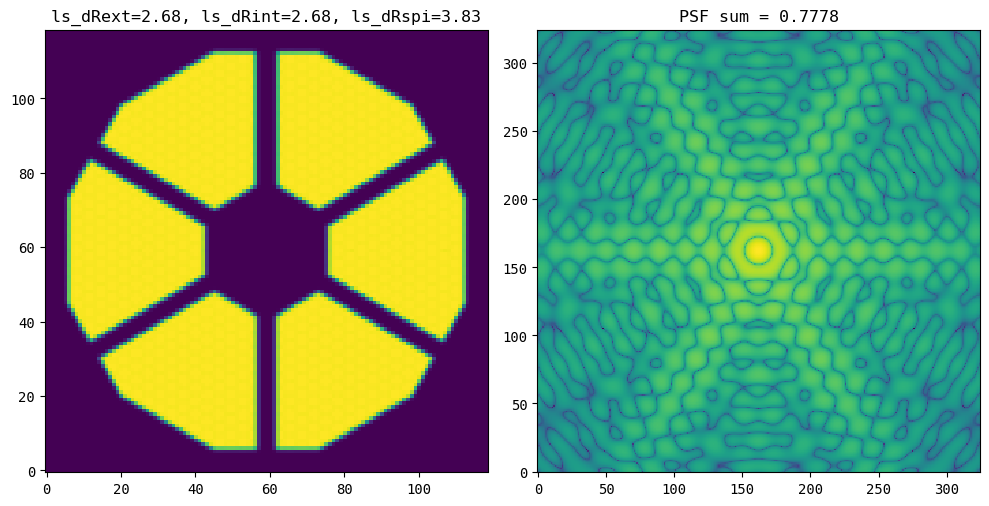

Processing case CLS-N:
ELT: fwhm=8.53pix, aper_flux=0.3776, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.7544
VPM transmittance = 0.9291
Mask throughput = 0.7493
Mode throughput = 0.6962
Encircled energy throughput = 0.5252
OAT @ 5 lambda/D = 0.8332
Encircled energy throughput @ 5 lambda/D = 0.4376


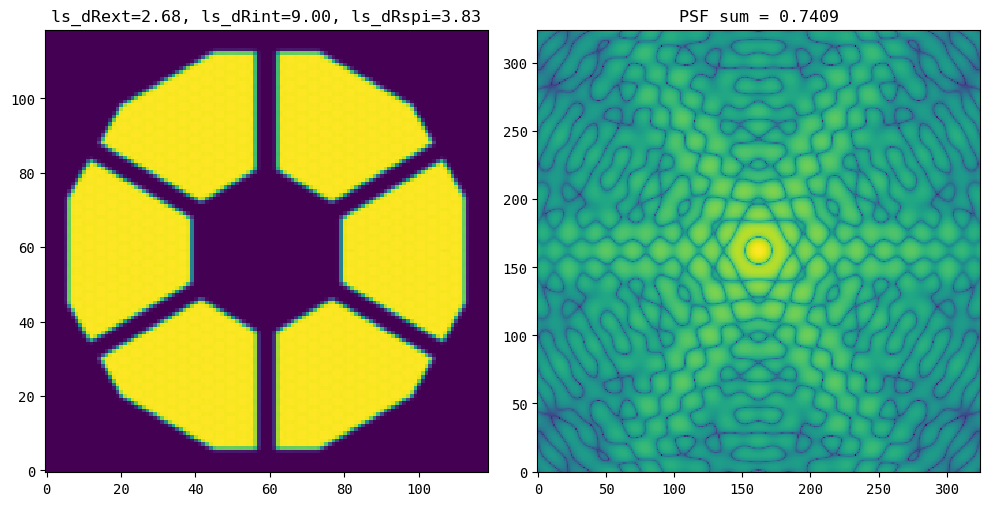

Processing case ULS-N:
ELT: fwhm=8.53pix, aper_flux=0.3776, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.6580
LOM transmittance = 0.9200
Mask throughput = 0.6189
Mode throughput = 0.5694
Encircled energy throughput = 0.3746


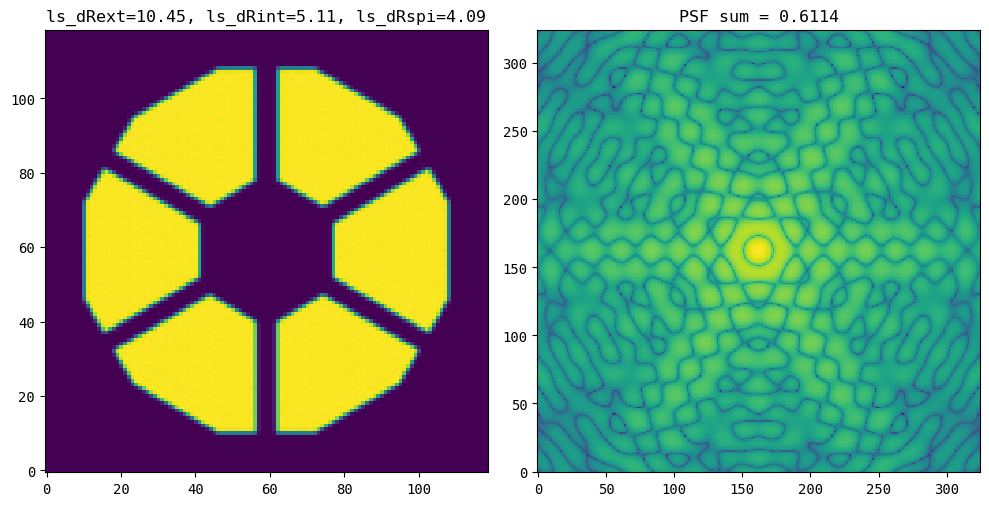

In [5]:
get_throughput(['IMG-N','CLS-N','ULS-N'])

# LMS modes

Processing case LMS:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
[Warning] Forcing spiders to have all the same sizes.
This mode FWHM throughput (wrt ELT) = 0.8051
Mask throughput = 0.7971
Mode throughput = 0.7971
Encircled energy throughput = 0.6417


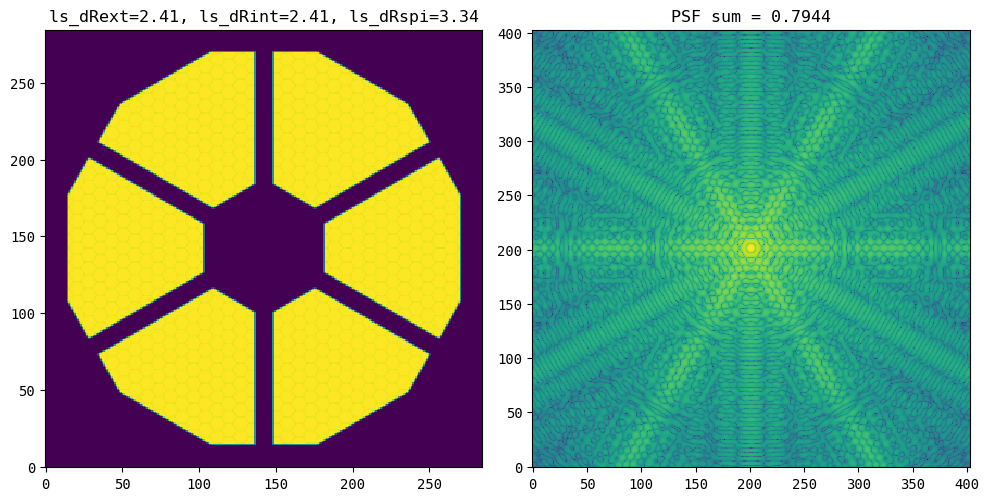

Processing case APP-LMS:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.5432
APP transmittance = 0.7334
Mask throughput = 0.7990
Mode throughput = 0.2813
Encircled energy throughput = 0.1528


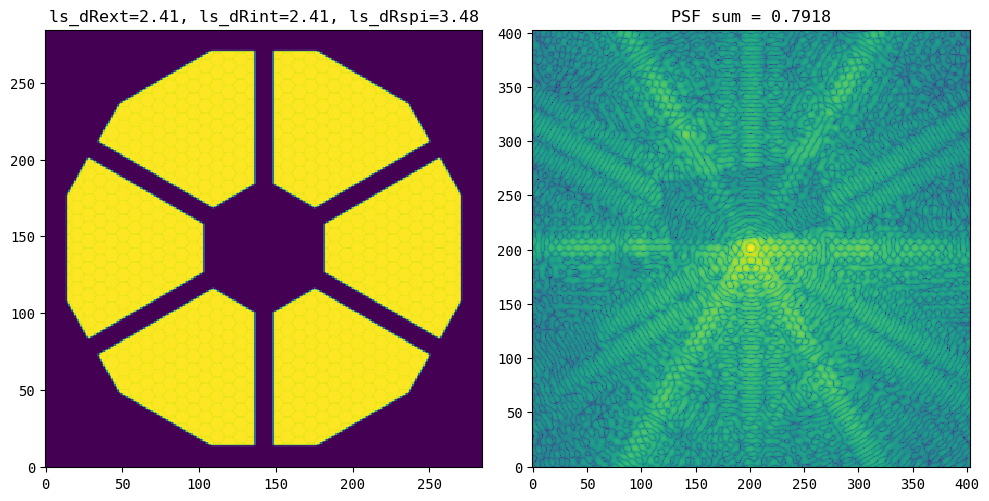

Processing case RLS-LMS:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
[Warning] Forcing spiders to have all the same sizes.
This mode FWHM throughput (wrt ELT) = 0.5547
VPM transmittance = 0.8532
Mask throughput = 0.3572
Mode throughput = 0.3048
Encircled energy throughput = 0.1691
OAT @ 5 lambda/D = 0.8828
Encircled energy throughput @ 5 lambda/D = 0.1492


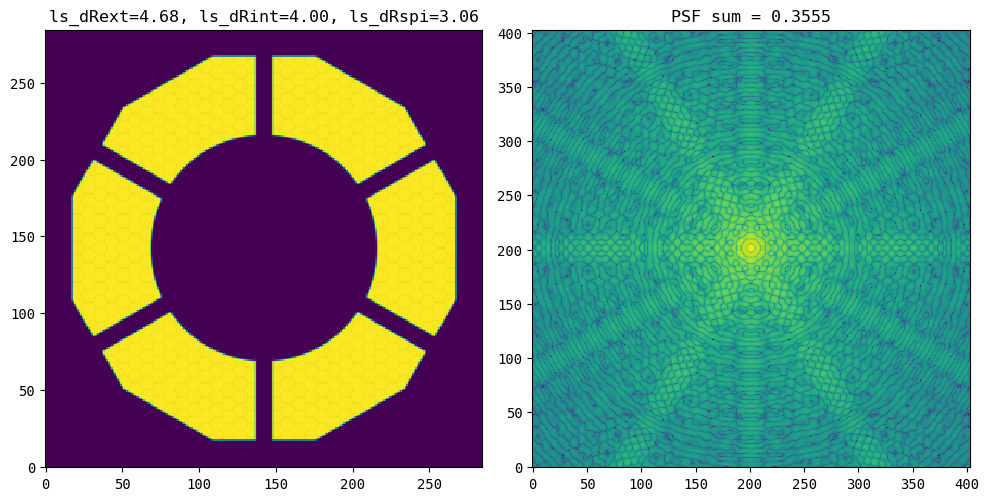

Processing case CLS-LMS:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
[Warning] Forcing spiders to have all the same sizes.
This mode FWHM throughput (wrt ELT) = 0.7658
VPM transmittance = 0.8532
Mask throughput = 0.7689
Mode throughput = 0.6560
Encircled energy throughput = 0.5024
OAT @ 5 lambda/D = 0.8190
Encircled energy throughput @ 5 lambda/D = 0.4115


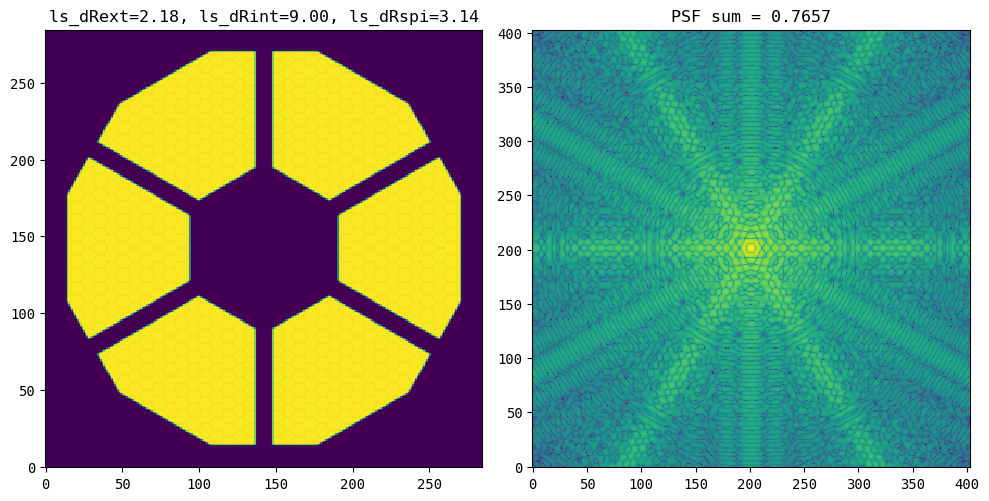

Processing case ULS-LMS:
ELT: fwhm=3.52pix, aper_flux=0.3608, (cx,cy)=(201.0,201.0)
[Warning] Forcing spiders to have all the same sizes.
This mode FWHM throughput (wrt ELT) = 0.6533
LOM transmittance = 0.9200
Mask throughput = 0.6205
Mode throughput = 0.5709
Encircled energy throughput = 0.3729


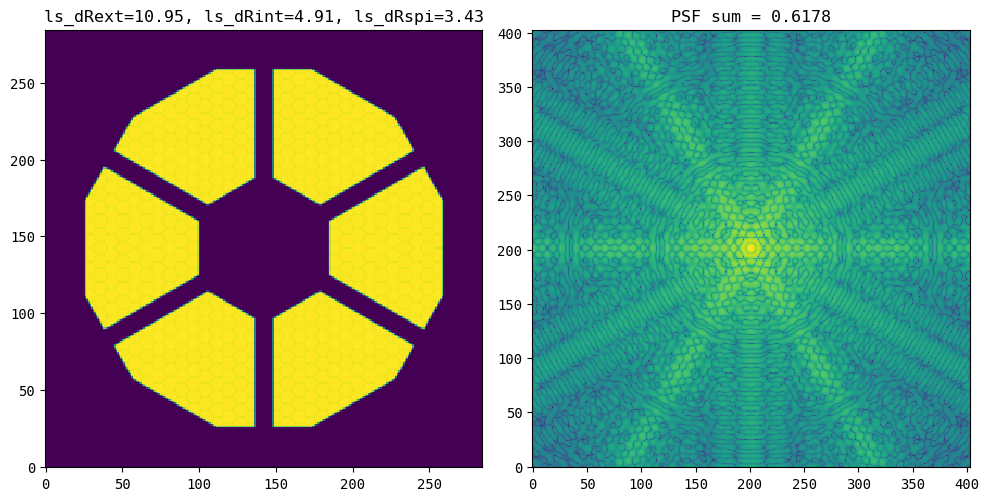

In [6]:
get_throughput(['LMS', 'APP-LMS', 'RLS-LMS', 'CLS-LMS', 'ULS-LMS']);